<a href="https://colab.research.google.com/github/marc1971/CAS_NLP_final_project/blob/main/final_project_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project

### Connecting to HuggingFace

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

### Connecting to GoogleDrive

In [ ]:
# Connecting to Google Drive to get access to data, that is used for training the model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Necessary imports

In [ ]:
!pip install -q -U torch==2.1.0 datasets transformers tensorflow langchain playwright html2text sentence_transformers faiss-cpu
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 trl==0.4.7 typing-extensions==4.6.1 pyarrow==14.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.1/816.1 kB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.4/37.4 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

### Dependencies

In [ ]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline
)
from datasets import load_dataset
from peft import LoraConfig, PeftModel

from langchain.text_splitter import CharacterTextSplitter
from langchain.document_transformers import Html2TextTransformer
from langchain.document_loaders import AsyncChromiumLoader

from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain

In [ ]:
#Helper Function to save Figures

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


IMAGES_PATH = '/content/drive/My Drive/ColabNotebooks/CAS_NLP_final_project/plots/'

### Load quantized Mistal 7B or 8x7B respectively

In [ ]:
model_name= 'mistralai/Mistral-7B-Instruct-v0.2'
# Huge Model Mistral 8: 'mistralai/Mixtral-8x7B-Instruct-v0.1'


#################################################################
# Tokenizer
#################################################################

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

#################################################################
# bitsandbytes parameters
#################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

#################################################################
# Set up quantization config
#################################################################
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16

if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

#################################################################
# Load pre-trained config
#################################################################
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

### Count number of trainable parameters

In [ ]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 262410240
all model parameters: 3752071168
percentage of trainable model parameters: 6.99%


### Build Mistral text generation pipeline

In [ ]:
text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=True,
    do_sample = True,
    max_new_tokens=1000,
)

In [ ]:
mistral_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

### Load and chunk documents. Load chunked documents into FAISS index

In [ ]:
!playwright install
!playwright install-deps

Installing dependencies...
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-freefont-ttf is already the newest version (20120503-10build1).
fonts-liberation is already the newest ve

## Loading Text Documents

The source of the text is different documents stored on Googledrive. There are actually 37 Documents with different number of characters.

In [ ]:
from text_loader import load_text
#from text_loader_clean import load_text

In [ ]:
dict_path = '/content/drive/My Drive/ColabNotebooks/CAS_NLP_final_project/Textdata/'
texts = load_text(dict_path, 'all')

In [ ]:
len(texts)

38

In [ ]:
print('Number of Documents: ',len(texts))
print('Nummer of Characters of the different Documents:', [len(texts[i]) for i in range(len(texts))])

Number of Documents:  38
Nummer of Characters of the different Documents: [1291, 15135, 7178, 12476, 30276, 24598, 24632, 4698, 2461, 2959, 23690, 18321, 16531, 10850, 4443, 2594, 18649, 11961, 12707, 29260, 6103, 32785, 4467, 2033, 2133, 32903, 21596, 3254, 24021, 24021, 21734, 6340, 4346, 17057, 32809, 13281, 9545, 21229]


In [ ]:
#Example of Document
texts[0]

'Reglement über die Aufgaben und Befugnisse der Vizerektorin oder des Vizerektors vom 20. Juni 2023.\nDer Rektor der Pädagogischen Hochschule, gestützt auf Artikel 10 Absatz 2 und Artikel 39 Absatz 1 Buchstabe n des Gesetzes vom 8. September 2004 über die deutschsprachige Pädagogische Hochschule (PHG)1 sowie in Ausführung von Artikel 3 Absatz 6 des Statuts der deutschsprachigen Pädagogischen Hochschule vom 12. Juni 2018 (PHSt)2, beschliesst: Dieses Reglement regelt die Zuweisung von Aufgaben der Rektorin oder des Rektors der Pädagogischen Hochschule an die Vizerektorin oder den Vizerektor sowie deren oder dessen Vertretungsbefugnis. Die Vizerektorin oder der Vizerektor hat während längerer Abwesenheiten der Rektorin oder des Rektors sämtliche Kompetenzen der- oder desselben inne, leitet das Programm «Strategisches Hochschulprozessmanagement», ist zuständig für die Bereichsleitungskonferenzen, kann die Rektorin oder den Rektor an Anlässen vertreten. Entscheidungen von grösserer Tragweit

## Text Analysis

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

Saving figure Zeichen_Dokumente


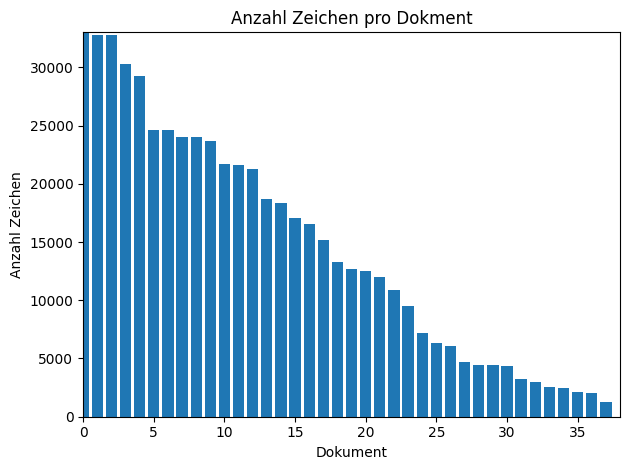

In [ ]:
#Characters per Dokument
y = [len(texts[i]) for i in range(len(texts))]
y = sorted(y, reverse = True)

x = [i for i in range(len([len(texts[i]) for i in range(len(texts))]))]

plt.bar(x, y)
plt.title('Anzahl Zeichen pro Dokment')
plt.xlim(0,len(x))
plt.ylim(0,33000)
plt.xlabel('Dokument')
plt.ylabel('Anzahl Zeichen')
save_fig('Zeichen_Dokumente')
plt.show()

In [ ]:
text_all = " ".join([str(text) for text in texts])
len(text_all)

554404

Häufigstes Vorkommen:  3288 mal
2743 Wörter kommen nur 1-mal vor im Text.
Saving figure wörter_vorkommen


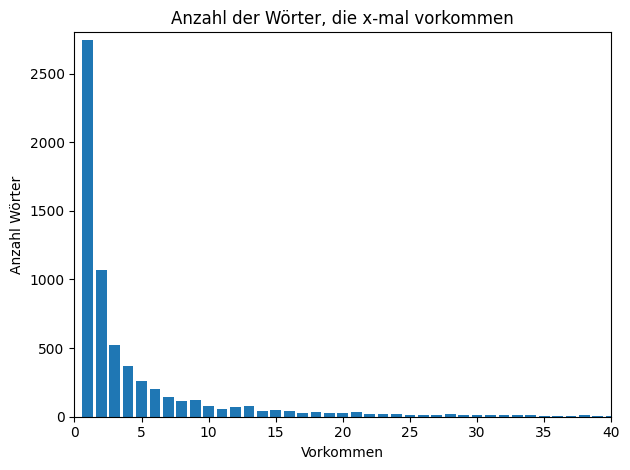

In [ ]:
from collections import Counter
import re


# Normalize the text to lowercase and remove non-alphanumeric characters
words = re.findall(r'\b\w+\b', text_all.lower())

# Count the words
word_counts = Counter(words)
counts = list(word_counts.values())
counts.sort()
c_counts = Counter(counts)

vorkommen = list(c_counts.keys())
anzahl = list(c_counts.items())
y = [tup[1] for tup in anzahl]

print('Häufigstes Vorkommen: ', max(vorkommen), 'mal')
print(max(y), 'Wörter kommen nur 1-mal vor im Text.')


plt.bar(vorkommen, y)
plt.title('Anzahl der Wörter, die x-mal vorkommen')
plt.xlim(0,40)
plt.ylim(0,2800)
plt.xlabel('Vorkommen')
plt.ylabel('Anzahl Wörter')
save_fig('wörter_vorkommen')
plt.show()

In [ ]:
#Unique Words count

unique_words = set(words)  # 'words' from the previous example
print(f"Number of unique words: {len(unique_words)}")

Number of unique words: 6570


Saving figure wörter_länge


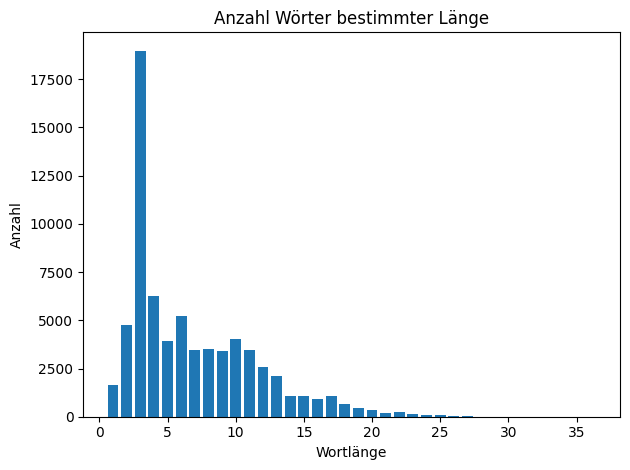

In [ ]:
word_lengths = [len(word) for word in words]
length_counts = Counter(word_lengths)

# Display the count of each word length
w_length = []
w_count = []
for length, count in sorted(length_counts.items()):
    w_length.append(length)
    w_count.append(count)
    #print(f"Length {length}: {count} times")

plt.bar(w_length, w_count)
plt.title('Anzahl Wörter bestimmter Länge')
plt.xlabel('Wortlänge')
plt.ylabel('Anzahl')
save_fig('wörter_länge')
plt.show()

In [ ]:
!pip install textstat
import textstat

readability_score = textstat.flesch_reading_ease(text_all)
print(f"Flesch Reading Ease: {readability_score}")

Flesch Reading Ease: 38.01


[(('für', 'die'), 273), (('die', 'studierenden'), 254), (('in', 'der'), 228), (('über', 'die'), 226), (('pädagogischen', 'hochschule'), 225), (('der', 'pädagogischen'), 213), (('an', 'der'), 150), (('ects', 'punkte'), 148), (('oder', 'der'), 141), (('für', 'den'), 134)]
Saving figure Bi_grams


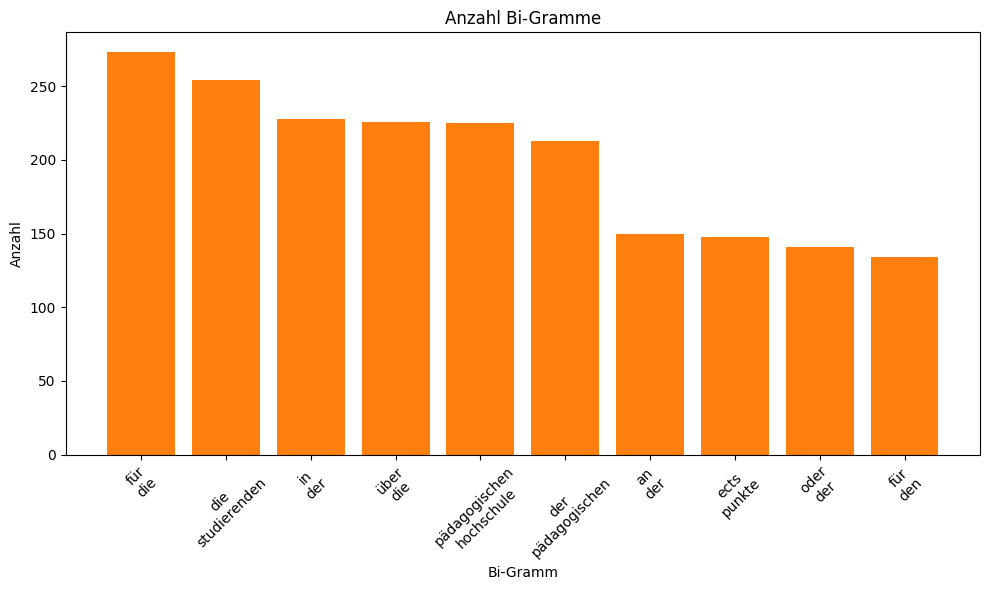

In [ ]:
from nltk.util import ngrams

bigrams = ngrams(words, 2)
bigram_counts = Counter(bigrams)
bigr = []
y = []

# Display the 5 most common bigrams
print(bigram_counts.most_common(10))
for bi in bigram_counts.most_common(10):
  bg, n = bi
  bigr.append(bg)
  y.append(n)

# Extracting labels from the tuples
x_labels = [f'{bi1}\n{bi2}' for bi1, bi2 in bigr]

# X values will be a range of numbers equal to the length of your labels list
x = range(len(bigr))

# Creating the plot
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size
plt.bar(x, y, tick_label=x_labels)
plt.xticks(rotation=45)

plt.bar(x, y)
plt.title('Anzahl Bi-Gramme')
plt.xlabel('Bi-Gramm')
plt.ylabel('Anzahl')
save_fig('Bi_grams')
plt.show()

## Split the Text in Chunks

### 1. Set up the CharacterTextSplitter to split then the Text in Chunks.

In [ ]:
from text_loader import text_splitting

In [ ]:
from langchain.text_splitter import CharacterTextSplitter
chunk_size = 500
overlap = 0

text_splitter = text_splitting(chunk_size, overlap, separator="")

### 2. Writing out the first line of each document, since it is the title of the document.

In [ ]:
from text_loader import get_text_before_newline

### 3. Creating a LangChain-Document

The Document *'documents'* is a list of LangChain-Objects, created with the help of the *'create_documents'*-methode of the TextSplitter that containes dicionaries with the keys *'page_content'* and *'metadata'*.

In [ ]:
from text_loader import create_LangChain_doc

In [ ]:
documents = create_LangChain_doc(texts, chunk_size, overlap, separator="")

In [ ]:
len(documents)

1129

In [ ]:
documents[10]

Document(page_content='und organisatorische Massnahmen gemäss den Artikeln 4 bis 6 der Datenschutzverordnung vom 22. Oktober 2008 zu schützen. Der Rechtsdienst erarbeitet hierzu eine Checkliste. Personendaten werden grundsätzlich nur bei den betroffenen Personen bzw. deren gesetzlichen Vertreterinnen und Vertretern beschafft. Bei systematischen Erhebungen muss die Rechtsgrundlage und der Zweck der Beschaffung angegeben sowie, falls keine Auskunftspflicht besteht, auf die Freiwilligkeit der Auskunft hingewiesen werden.', metadata={'document': 'Weisungen über den Umgang mit Personendaten (Datenschutzweisungen) vom 29. Juni 2021.'})

In [ ]:
print(type(documents[1]))
print(len(documents[1].page_content))
print(documents[7].page_content)
print(documents[1].metadata)

<class 'langchain_core.documents.base.Document'>
499
schutzrecht verstösst; Mitarbeiterinnen und Mitarbeiter: Mitarbeiterinnen und Mitarbeiter der Pädagogischen Hochschule gemäss Artikel 11 Absatz 2 PHG. Die Mitarbeiterinnen und Mitarbeiter bearbeiten Personendaten nur, wenn und soweit sie durch Gesetz oder Verordnung dazu ermächtigt werden oder b dies für die Erfüllung ihrer dienstrechtlichen Verpflichtungen gegenüber der Pädagogischen Hochschule erforderlich ist. Die Mitarbeiterinnen und Mitarbeiter bearbeiten besonders schützenswerte Personenda
{'document': 'Reglement über die Aufgaben und Befugnisse der Vizerektorin oder des Vizerektors vom 20. Juni 2023.'}


As expected the length of the content in each entry is 500 (499) characters. (no idea why 499???)

### 4. Splitting the LangChain-Document in Chunks

Now we have to make a List of all Document-Entries. It can be done with the *'split_documents'*-methode.

In [ ]:
from text_loader import chunk_docs

In [ ]:
chunked_documents = chunk_docs(documents,chunk_size, overlap, separator="")

In [ ]:
print(len(chunked_documents))

1129


## Creating a Vector-Database and building a Retriever

In [ ]:
# Load chunked documents into the FAISS index
db = FAISS.from_documents(chunked_documents,
                          HuggingFaceEmbeddings(model_name='PM-AI/bi-encoder_msmarco_bert-base_german'))

# Connect query to FAISS index using a retriever

retriever = db.as_retriever(
    search_type="similarity",
    search_kwargs={'k': 4}
)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/729k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Create PromptTemplate and LLMChain

In [ ]:
prompt_template = """
### [INST]

Instruction: Beantworte die Frage aufgrund deines Wissens über die PHBern. Antworte in **ZWEI bis DREI DEUTSCHEN Sätzen**! Hier ist der Kontext als Hilfe:

{context}

### QUESTION:
{question}

[/INST]
 """

# Create prompt from prompt template
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

# Create llm chain by pasting together the Text_generation-Pipeline 'mistral_lmm' and the prompt
llm_chain = LLMChain(llm=mistral_llm, prompt=prompt)


#Answer the question based on your knowledge about PHBern. Answer in german! Here is context to help:

In [ ]:
llm_chain.invoke({"context": "", "question": "Wie lange werden meine Arbeitszeugnisse an der PHBern aufbewahrt?"})

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'context': '',
 'question': 'Wie lange werden meine Arbeitszeugnisse an der PHBern aufbewahrt?',
 'text': ' Die PH Bern bewahrt Arbeitszeugnisse mindestens zehn Jahre und maximal fünfzig Jahre auf.\n  Sie entscheiden die Laufzeit je nach Art des Zeugnisses.'}

### Build RAG Chain

The RAG Chain finally is the all glued together: the Generator-Pipeline *'mistral_lmm'*, the *PromptTemplate* (prompt), augmented by an external context, found by the *retriever*!

In [ ]:
rag_chain = ( {"context": retriever, "question": RunnablePassthrough()} | llm_chain )

result = rag_chain.invoke("Wie lange werden meine Arbeitszeugnisse an der PHBern aufbewahrt?")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
result['context']

[Document(page_content='erenden des Abschlusskolloquiums, spätestens jedoch zwei Wochen vor dem Abschlusskolloquium. Die Zeitfenster sind im Anlassverzeichnis aufgeführt. Die Studierenden arbeiten während der gesamten Ausbildung am IS2 der PHBern am Berufskonzept. Sie schreiben sich in die Lerngelegenheiten des Moduls Transfer und Vernetzung parallel zur Einschreibung in die Module Einführungspraktikum und/oder Fachpraktikum wie folgt ein: Lerngelegenheit, Voraussetzung, Einschreibung, Orientierungstag. Es erfolgt auto', metadata={'document': 'Wegleitung TRANSFER UND VERNETZUNG.'}),
 Document(page_content='Informationen des Rechtsdiensts zur Entschädigung bei Praktika.\nDie Studierenden der PHBern absolvieren in allen Grundausbildungsstudiengängen eine Berufspraktische Ausbildung. Diese besteht aus „praktisch angelegten, professionell begleiteten Lehr- und Lernanlässen, welche im unmittelbaren Kontakt mit dem Berufsfeld der Förderung der Handlungskompetenz als Lehrperson dienen“, und d

In [ ]:
print(result['text'])

 Die Arbeitszeugnisse werden zehn Jahre nach dem Stellenaustritt vernichtet. (Zehn Jahre nach dem Ausscheiden aus der PHBern werden die Arbeitszeugnisse aufbewahrt und anschließend vernichtet.)


## Benchmarking

Here we check the similarity between the resulting answers of our RAG and the ground truth answers. Therefore we load en Exel File wich 1030 Q+As.

In [ ]:
import pandas as pd

df = pd.read_excel(r"/content/drive/My Drive/ColabNotebooks/CAS_NLP_final_project/QA.xlsx")


Apply the RAG-Chain to all the Questions in the Q+A Document and make a new column with predictions.

In [ ]:
from tqdm import tqdm

In [ ]:
len(df)

1033

In [ ]:
n_preds = 200 #len(df)

df['pred'] = df['question'][:n_preds].apply(lambda x: rag_chain.invoke(x)['text'])

In [ ]:
df.head()

,id,title,question,answer,context,document,Unnamed: 6,Unnamed: 7,Unnamed: 8,pred
0,1,Reglement über die Aufgaben und Befugnisse der...,"Was geschieht, wenn der Rektor oder die Rektor...",Die Vizerektorin oder der Vizerektor hat währe...,"Der Rektor der Pädagogischen Hochschule, gestü...","Der Rektor der Pädagogischen Hochschule, gestü...",NaN,NaN,NaN,1. In der Abwesenheit der Rektorin or des Rekt...
1,2,Reglement über die Aufgaben und Befugnisse der...,Welche Befugnisse hat die Vizerektorin oder de...,Sie oder er leitet das Programm «Strategisches...,"Der Rektor der Pädagogischen Hochschule, gestü...","Der Rektor der Pädagogischen Hochschule, gestü...",NaN,NaN,NaN,Die Vizerektorin oder der Vizerektor hat währ...
2,3,Reglement über die Aufgaben und Befugnisse der...,Kann die Vizerektorin oder der Vizerektor in A...,Entscheidungen von grösserer Tragweite fällt d...,"Der Rektor der Pädagogischen Hochschule, gestü...","Der Rektor der Pädagogischen Hochschule, gestü...",NaN,NaN,NaN,"Ja, die Vizerektorin oder der Vizerektor kann..."
3,4,Weisungen über den Umgang mit Personendaten (D...,Was sind Personendaten?,Personendaten sind sämtliche Angaben über eine...,Diese Weisungen regeln den Umgang mit Personen...,Diese Weisungen regeln den Umgang mit Personen...,NaN,NaN,NaN,Personendaten sind alle Angaben über eine nat...
4,5,Weisungen über den Umgang mit Personendaten (D...,Was sind besonders schützenswerte Personendaten?,Besonders schützenswerte Personendaten sind Da...,Diese Weisungen regeln den Umgang mit Personen...,Diese Weisungen regeln den Umgang mit Personen...,NaN,NaN,NaN,1. Besonders schützenswerte Personendaten umfa...


In [ ]:
df.to_excel(r"/content/drive/My Drive/ColabNotebooks/CAS_NLP_final_project/QA_pred1.xlsx", index=False)

In [ ]:
df[['question', 'answer', 'pred']].head()

,question,answer,pred
0,"Was geschieht, wenn der Rektor oder die Rektor...",Die Vizerektorin oder der Vizerektor hat währe...,"1. Es gibt keine genauen Angaben im Text, wer ..."
1,Welche Befugnisse hat die Vizerektorin oder de...,Sie oder er leitet das Programm «Strategisches...,Die Vizerektorin bzw. der Vizerektor unterstü...
2,Kann die Vizerektorin oder der Vizerektor in A...,Entscheidungen von grösserer Tragweite fällt d...,1. In der Absenz des Rektors kann die Vizerekt...
3,Was sind Personendaten?,Personendaten sind sämtliche Angaben über eine...,Personendaten sind natürliche und juristische...
4,Was sind besonders schützenswerte Personendaten?,Besonders schützenswerte Personendaten sind Da...,1. Besondere Schützenswerte haben Personenbezo...


### Calculating Cosine-Similatities

In [ ]:
import pandas as pd

df_pred = pd.read_excel(r"/content/drive/My Drive/ColabNotebooks/CAS_NLP_final_project/QA_predM8_1000_full.xlsx")

In [ ]:
len(df_pred)

1033

In [ ]:
df_pred.head()

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch
from scipy.spatial.distance import cosine
import numpy as np

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('PM-AI/bi-encoder_msmarco_bert-base_german')
model = AutoModel.from_pretrained('PM-AI/bi-encoder_msmarco_bert-base_german')



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/729k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
s1 = df_pred['answer'].to_list()
s2 = df_pred['pred'].to_list()

len(s2)

1033

In [ ]:
# Define your sentences
cos_sim = []

for i in range(200):
  sentence1 = s1[i]
  sentence2 = s2[i]
# Tokenize the sentences
  tokens1 = tokenizer(sentence1, return_tensors='pt', padding=True, truncation=True)
  tokens2 = tokenizer(sentence2, return_tensors='pt', padding=True, truncation=True)

# Generate embeddings
  with torch.no_grad():
    embeddings1 = model(**tokens1).last_hidden_state.mean(dim=1)
    embeddings2 = model(**tokens2).last_hidden_state.mean(dim=1)

# Calculate cosine similarity
  cosine_similarity = 1 - cosine(embeddings1[0].numpy(), embeddings2[0].numpy())
  cos_sim.append(cosine_similarity)

In [ ]:
n_preds = len(cos_sim)
print(len(cos_sim))

200


In [ ]:
df_pred['similarity'] = np.nan  # Initialize the column with NaN
df_pred.loc[:n_preds-1, 'similarity'] = cos_sim

In [ ]:
df_pred[['question', 'answer', 'pred', 'similarity']][:n_preds]

,question,answer,pred,similarity
0,"Was geschieht, wenn der Rektor oder die Rektor...",Die Vizerektorin oder der Vizerektor hat währe...,1. In der Abwesenheit der Rektorin or des Rekt...,0.979311
1,Welche Befugnisse hat die Vizerektorin oder de...,Sie oder er leitet das Programm «Strategisches...,Die Vizerektorin oder der Vizerektor hat währ...,0.981290
2,Kann die Vizerektorin oder der Vizerektor in A...,Entscheidungen von grösserer Tragweite fällt d...,"Ja, die Vizerektorin oder der Vizerektor kann...",0.989753
3,Was sind Personendaten?,Personendaten sind sämtliche Angaben über eine...,Personendaten sind alle Angaben über eine nat...,0.982921
4,Was sind besonders schützenswerte Personendaten?,Besonders schützenswerte Personendaten sind Da...,1. Besonders schützenswerte Personendaten umfa...,0.995259
...,...,...,...,...
195,Wie kann ich mich im Bachelorstudiengang PS vo...,Abmeldungen von Modularbeiten müssen bis späte...,1. Abmeldungen von Modularbeiten müssen schrif...,0.991253
196,Welche Frist gilt für die Abmeldung von einem ...,Abmeldungen von Praktika müssen bis spätestens...,1. Praktikumsmeldungen müssen vor der verbindl...,0.981638
197,"Was geschieht, wenn ich ohne Vorliegen wichtig...","Wer ohne Vorliegen wichtiger Gründe, insbesond...",1. Für den betreffenden Leistungsnachweis beko...,0.984606
198,"Was geschieht, wenn ich ohne Vorliegen wichtig...","Wer ohne Vorliegen wichtiger Gründe, insbesond...",1. Wenn Sie ohne wichtige Gründe eine Prüfung ...,0.991914


In [ ]:
mean_sim = np.mean(cos_sim)
print(mean_sim)
print(max(cos_sim))
print(min(cos_sim))

0.9780655243992805
1
0.9400752186775208


### Calculating BertScore

In [ ]:
import os

os.environ["LC_ALL"] = "ge.UTF-8"
os.environ["LANG"] = "ge.UTF-8"

In [ ]:
!pip install evaluate

In [ ]:
!pip install bert_score

In [ ]:
from evaluate import load
bertscore = load("bertscore")
#alternative models: bert-base-multilingual-cased (as bbmc), distilbert-base-uncased (as dbu), PM-AI/bi-encoder_msmarco_bert-base_german (as mbbg), xlm-roberta-base (as xrb), bert-base-german-uc (as bbgu)
model_type = 'xlm-roberta-base'
ext = '_xrb'

BSC_pre = []
BSC_rec = []
BSC_f1 = []

n_pred = 1033
for i in range(n_pred):
  predictions = [df_pred['pred'][i]]
  references = [df_pred['answer'][i]]
  results = bertscore.compute(predictions=predictions, references=references, model_type= model_type)
  #alternative: bert-base-multilingual-cased (as bbmc), distilbert-base-uncased (as dbu)
  BSC_pre.append(results[['precision'][0]])
  BSC_rec.append(results[['recall'][0]])
  BSC_f1.append(results[['f1'][0]])


In [ ]:
import numpy as np

df_pred['BSC_pre{}'.format(ext)] = np.nan  # Initialize the column with NaN
df_pred['BSC_rec{}'.format(ext)] = np.nan  # Initialize the column with NaN
df_pred['BSC_f1{}'.format(ext)] = np.nan  # Initialize the column with NaN
df_pred.loc[:n_pred-1, 'BSC_pre{}'.format(ext)] = BSC_pre
df_pred.loc[:n_pred-1, 'BSC_rec{}'.format(ext)] = BSC_rec
df_pred.loc[:n_pred-1, 'BSC_f1{}'.format(ext)] = BSC_f1



In [ ]:
print(len(df_pred))
n_pred = 1033
df_pred[['question', 'answer', 'pred', 'similarity', 'BSC_pre{}'.format(ext),'BSC_rec{}'.format(ext), 'BSC_f1{}'.format(ext)]][:n_pred]

1033


,question,answer,pred,similarity,BSC_pre_xrb,BSC_rec_xrb,BSC_f1_xrb
0,"Was geschieht, wenn der Rektor oder die Rektor...",Die Vizerektorin oder der Vizerektor hat währe...,\nLaut dem Reglement über die Aufgaben und Bef...,0.988163,0.859676,0.904862,0.881691
1,Welche Befugnisse hat die Vizerektorin oder de...,Sie oder er leitet das Programm «Strategisches...,Laut dem Reglement über die Aufgaben und Befu...,0.977954,0.820581,0.954101,0.882318
2,Kann die Vizerektorin oder der Vizerektor in A...,Entscheidungen von grösserer Tragweite fällt d...,"Ja, laut dem Reglement über die Aufgaben und ...",0.985102,0.866966,0.894931,0.880726
3,Was sind Personendaten?,Personendaten sind sämtliche Angaben über eine...,Personendaten sind alle Angaben über eine bes...,0.981643,0.804088,0.960788,0.875481
4,Was sind besonders schützenswerte Personendaten?,Besonders schützenswerte Personendaten sind Da...,\nBesonders schützenswerte Personendaten sind ...,0.998193,0.968483,0.966403,0.967442
...,...,...,...,...,...,...,...
1028,"Woher bekomme ich das Formular, um ein Praktik...",Das Formular Abbruch Praktikum kann bei der Be...,Gemäss den Studienreglementen der PH Bern kan...,0.948755,0.802467,0.879953,0.839425
1029,"Was geschieht, wenn ich einen wichtigen Grund ...",Liegt ein wichtiger Grund für den Abbruch des ...,\nLaut dem Studienreglement für das Bachelor- ...,0.979298,0.830879,0.871832,0.850863
1030,Kann ich mit einer ungenügenden Prüfungslektio...,Ein ungenügender Leistungsnachweis Prüfungslek...,Laut den Allgemeinen Zulassungsweisungen vom ...,0.972388,0.807819,0.844348,0.825680
1031,Gibt es am IS2 der Phbern ein Verfahren zur Pr...,Am IS2 der PHBern findet die Prüfung der Eignu...,\nAufgrund der bereitgestellten Informationen ...,0.975014,0.843504,0.873499,0.858239


In [ ]:
df_pred.to_excel(r"/content/drive/My Drive/ColabNotebooks/CAS_NLP_final_project/QA_M8_1000_full_bbmc.xlsx", index=False)

In [ ]:
mean_BSC_pre = np.mean(BSC_pre)
mean_BSC_rec = np.mean(BSC_rec)
mean_BSC_f1 = np.mean(BSC_f1)
print(mean_BSC_pre, mean_BSC_rec, mean_BSC_f1)

0.7063777294417434 0.7774837701387581 0.7391306843900727


In [ ]:
import pandas as pd

df_pred2 = pd.read_excel(r"/content/drive/My Drive/ColabNotebooks/CAS_NLP_final_project/QA_M8_1000_full_bbmc.xlsx")

In [ ]:
df_pred2.tail()

In [ ]:
max(BSC_pre)[0]

0.9941324591636658

In [ ]:
import numpy as np

rounding = 4


mean_BSC_pre = round(np.mean(df_pred2['BSC_pre{}'.format(ext)]),rounding)
mean_BSC_rec = round(np.mean(df_pred2['BSC_rec{}'.format(ext)]),rounding)
mean_BSC_f1 = round(np.mean(df_pred2['BSC_f1{}'.format(ext)]),rounding)
std_BSC_pre = round(np.std(df_pred2['BSC_pre{}'.format(ext)]),rounding)
std_BSC_rec = round(np.std(df_pred2['BSC_rec{}'.format(ext)]),rounding)
std_BSC_f1 = round(np.std(df_pred2['BSC_f1{}'.format(ext)]),rounding)
max_BSC_pre = round(max(df_pred2['BSC_pre{}'.format(ext)]),rounding)
max_BSC_rec = round(max(df_pred2['BSC_rec{}'.format(ext)]),rounding)
max_BSC_f1 = round(max(df_pred2['BSC_f1{}'.format(ext)]),rounding)
min_BSC_pre = round(min(df_pred2['BSC_pre{}'.format(ext)]),rounding)
min_BSC_rec = round(min(df_pred2['BSC_rec{}'.format(ext)]),rounding)
min_BSC_f1 = round(min(df_pred2['BSC_f1{}'.format(ext)]),rounding)

print('Precission: \nMean: ', mean_BSC_pre, '\nStdev: ', std_BSC_pre, '\nMax_Value: ', max_BSC_pre, '\nMin_Value: ', min_BSC_pre)
print()
print('Recall: \nMean: ', mean_BSC_rec, '\nStdev: ', std_BSC_rec, '\nMax_Value: ', max_BSC_rec, '\nMin_Value: ', min_BSC_rec)
print()
print('F1-Score: \nMean: ', mean_BSC_f1, '\nStdev: ', std_BSC_f1, '\nMax_Value: ', max_BSC_f1, '\nMin_Value: ', min_BSC_f1)


Precission: 
Mean:  0.7064 
Stdev:  0.0713 
Max_Value:  0.9893 
Min_Value:  0.5655

Recall: 
Mean:  0.7775 
Stdev:  0.0821 
Max_Value:  0.9916 
Min_Value:  0.6048

F1-Score: 
Mean:  0.7391 
Stdev:  0.0706 
Max_Value:  0.9904 
Min_Value:  0.6093


In [ ]:
badest_pre = df_pred2[['answer', 'pred']][df_pred2['BSC_pre{}'.format(ext)] == min(df_pred2['BSC_pre{}'.format(ext)])]
badest_pre

,answer,pred
438,Auswärtige Masterarbeiten können nicht angerec...,"\nNein, laut dem Studienreglement für den Mast..."


In [ ]:
best_pre = df_pred2[['answer', 'pred']][df_pred2['BSC_pre{}'.format(ext)] == max(df_pred2['BSC_pre{}'.format(ext)])]
best_pre


,answer,pred
141,Die Gebühr für die Anmeldung zum «admission su...,Die Gebühr für die Anmeldung zum «admission s...


In [ ]:

df_pred2_miss = df_pred2[['question', 'answer', 'pred']][df_pred2['BSC_pre{}'.format(ext)]<0.8]
print(len(df_pred2_miss))
df_pred2_miss

In [ ]:
import seaborn as sns

<Axes: ylabel='BSC_f1_xrb'>

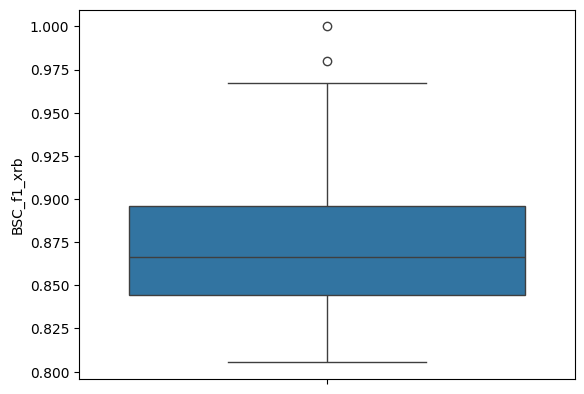

In [ ]:
sns.boxplot(y=df_pred2['BSC_f1{}'.format(ext)])


<Axes: ylabel='similarity'>

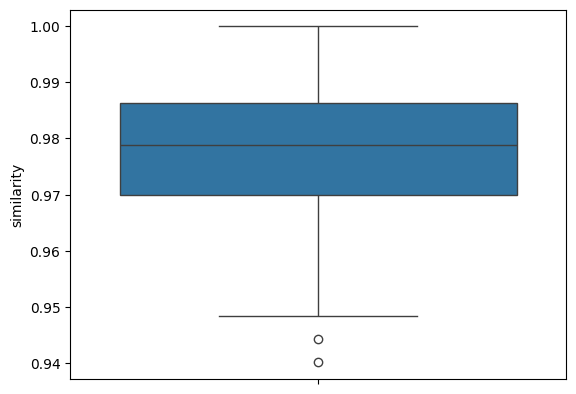

In [ ]:
sns.boxplot(y=df_pred2["similarity"])

In [ ]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


IMAGES_PATH = '/content/drive/My Drive/ColabNotebooks/CAS_NLP_final_project/plots/'

Saving figure benchmark_M8_1000_full_bbmc


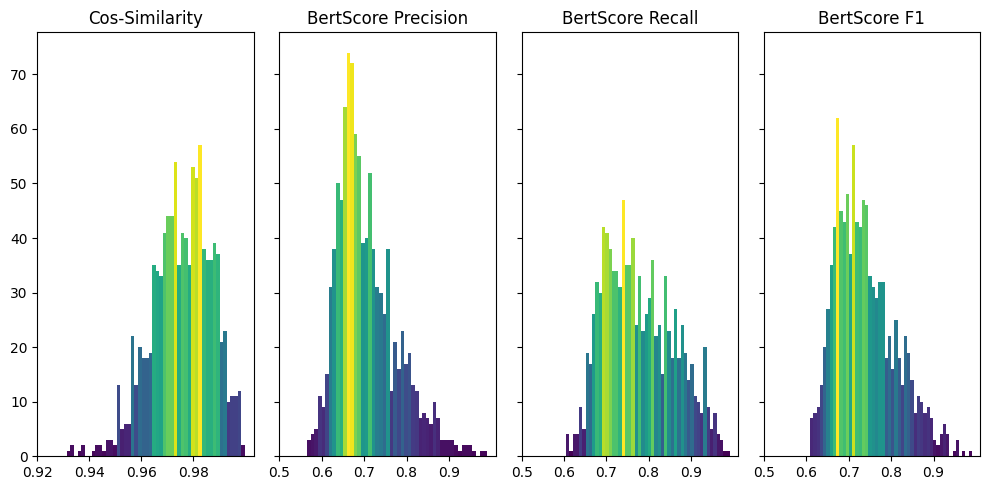

In [ ]:
import matplotlib.pyplot as plt

from matplotlib import colors
from matplotlib.ticker import PercentFormatter

n_bins = 50
#ext = '_xrb'

x1 = df_pred2["similarity"]
x2 = df_pred2['BSC_pre{}'.format(ext)]
x3 = df_pred2['BSC_rec{}'.format(ext)]
x4 = df_pred2['BSC_f1{}'.format(ext)]


fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True, figsize=(10,5))

# We can set the number of bins with the *bins* keyword argument.
#axs[0].hist(x1, bins=n_bins)
#axs[1].hist(x2, bins=n_bins)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs[0].hist(x1, bins=n_bins)


# We'll color code by height, but you could use any scalar
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

# N is the count in each bin, bins is the lower-limit of the bin
N2, bins2, patches2 = axs[1].hist(x2, bins=n_bins)


# We'll color code by height, but you could use any scalar
fracs2 = N2 / N2.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm2 = colors.Normalize(fracs2.min(), fracs2.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs2, patches2):
    color = plt.cm.viridis(norm2(thisfrac))
    thispatch.set_facecolor(color)

# N is the count in each bin, bins is the lower-limit of the bin
N3, bins3, patches3 = axs[2].hist(x3, bins=n_bins)


# We'll color code by height, but you could use any scalar
fracs3 = N3 / N3.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm3 = colors.Normalize(fracs3.min(), fracs3.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs3, patches3):
    color = plt.cm.viridis(norm3(thisfrac))
    thispatch.set_facecolor(color)

# N is the count in each bin, bins is the lower-limit of the bin
N4, bins4, patches4 = axs[3].hist(x4, bins=n_bins)


# We'll color code by height, but you could use any scalar
fracs4 = N4 / N4.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm4 = colors.Normalize(fracs4.min(), fracs4.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs4, patches4):
    color = plt.cm.viridis(norm4(thisfrac))
    thispatch.set_facecolor(color)

xticks = np.arange(0.5, 1, 0.1)


axs[0].set_title('Cos-Similarity')
axs[0].set_xticks(np.arange(0.92, 1, 0.02))

axs[1].set_title('BertScore Precision')
axs[1].set_xticks(xticks)

axs[2].set_title('BertScore Recall')
axs[2].set_xticks(xticks)

axs[3].set_title('BertScore F1')
axs[3].set_xticks(xticks)

save_fig('benchmark_M8_1000_full{}'.format(ext))
